# Theory and Function Explanations for Option Pricing and Monte Carlo Simulation

## Imports and Option Type Enumeration




In [2]:
i=1j # setting large imagnery number
class OptionType(enum.Enum):
    Call=1.0
    Put=-1.0

In [3]:
def bs_call_put_option_price(cp,S_0,K,sigma,tau,r):
    K=np.array(K).reshape([len(K),1])
    d1=((np.log(S_0/K)+(r+0.5*sigma**2)*tau))/float(sigma*np.sqrt(tau))
    d2=d1-sigma*np.sqrt(tau)
    if cp==OptionType.Call:
        value=(sats.norm.cdf(d1)*S_0)-(K*np.exp(-r*tau)*sats.norm.cdf(d2))
    elif cp==OptionType.Put:
        value=(K*np.exp(-r*tau)*sats.norm.cdf(-d2))-(sats.norm.cdf(-d1)*S_0)
    return value

In [4]:
def GeneratePathsGBMEuler(NoOfPaths,NoOfSteps,T,r,sigma,S_0):
    Z=np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W=np.zeros([NoOfPaths,NoOfSteps+1])
    # eulier apprximation s1
    S1=np.zeros([NoOfPaths,NoOfSteps+1])
    S1[:, 0] = S_0
    time=np.zeros([NoOfSteps+1])
    dt=T/float(NoOfSteps)
    for i in range(0,NoOfSteps):
        if NoOfPaths>1:
            Z[:,i] = (Z[:,i]-np.mean(Z[:,i]))/np.std(Z[:,i])# normalized your bitchs
        W[:,i+1]=W[:,i]+np.power(dt,0.5)*Z[:,i]
        S1[:,i+1]=S1[:,i]+r*S1[:,i]*dt+sigma*S1[:,i]*(W[:,i+1]-W[:,i])
        time[i+1]=time[i]+dt
    paths={'time':time,'S':S1}
    return paths

In [5]:
def BS_Cash_Or_Nothing_Price(cp,S_0,K,sigma,tau,r):
    K=np.array(K).reshape(len(K),1)
    d1=((np.log(S_0/K)+(r+0.5*sigma**2)*tau))/float(sigma*np.sqrt(tau))
    d2=d1-sigma*np.sqrt(tau)
    if cp==OptionType.Call:
        value=K*np.exp(-r*tau)*sats.norm.cdf(d2)
    elif cp==OptionType.Put:
        value=K*np.exp(-r*tau)*(1.0-sats.norm.cdf(d2))
    return value

In [6]:
def GeneratePathsGBMMilstein(NoOfPaths,NoOfSteps,T,r,sigma,S_0):
    Z=np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W=np.zeros([NoOfPaths,NoOfSteps+1])
    # eulier apprximation s1
    S1=np.zeros([NoOfPaths,NoOfSteps+1])
    S1[:, 0] = S_0
    time=np.zeros([NoOfSteps+1])
    dt=T/float(NoOfSteps)
    for i in range(0,NoOfSteps):
        if NoOfPaths>1:
            Z[:,i] = (Z[:,i]-np.mean(Z[:,i]))/np.std(Z[:,i])# normalized your bitchs
        W[:,i+1]=W[:,i]+np.power(dt,0.5)*Z[:,i]
        S1[:,i+1]=S1[:,i]+r*S1[:,i]*dt+sigma*S1[:,i]*(W[:,i+1]-W[:,i])+0.5*sigma**2.0*S1[:,i]*((W[:,i+1]-W[:,i])**2-dt)
        time[i+1]=time[i]+dt
    paths={'time':time,'S':S1}
    return paths

In [7]:
def europianPriceFromMCPaths(cp,S,K,T,r):
    if cp==OptionType.Call:
        return np.exp(-r*T)*np.mean(np.maximum(S-K,0.0))
    elif cp==OptionType.Put:
        return np.exp(-r*T)*np.mean(np.maximum(K-S,0.0))
def cashorNothingPriceFromMCPaths(cp,S,K,T,r):
    if cp==OptionType.Call:
        return np.exp(-r*T)*K*np.mean((S>K))
    elif cp==OptionType.Put:
        return np.exp(-r*T)*K*np.mean((S<=K))

In [8]:
def ploting(NoOfSteps, T, r, sigma, S_0):
    NoOfPaths=[10]
    np.random.seed(1)
    PathsEuler = GeneratePathsGBMEuler(NoOfPaths, NoOfSteps, T, r, sigma, S_0)
    np.random.seed(1)
    PathsMilstein = GeneratePathsGBMMilstein(NoOfPaths, NoOfSteps, T, r, sigma, S_0)
    plt.figure(1)
    plt.plot(PathsEuler["time"], PathsEuler["S"].T, linewidth=0.5)
    plt.title("Simulated Paths of the Underlying Asset (Euler Scheme)")
    plt.xlabel("Time")
    plt.ylabel("Asset Price")
    plt.grid()
    
    plt.figure(2)
    plt.plot(PathsMilstein["time"], PathsMilstein["S"].T, linewidth=0.5)
    plt.title("Simulated Paths of the Underlying Asset (Milstein Scheme)")
    plt.xlabel("Time")
    plt.ylabel("Asset Price")
    plt.grid()
    plt.show()

In [9]:
def mainCalculation():
    cp = OptionType.Call
    T = 1
    r = 0.06
    sigma = 0.3
    S_0 = 5
    K = [S_0]
    NoOfSteps = 1000
    NoOfPathsV = [100, 1000, 5000, 10000]
    exactPrice=bs_call_put_option_price(cp, S_0, K, sigma, T, r)[0]
    NoOfPaths = 10  # Number of paths to plot
    
    print("EUROPEAN OPTION PRICING by bs")
    print("Exact option price = {0}".format(exactPrice))
    
    pricesEuler = []
    pricesMilstein = []
    for noOfpathtemp in NoOfPathsV:
        np.random.seed(1)
        PathsEuler = GeneratePathsGBMEuler(noOfpathtemp, NoOfSteps, T, r, sigma, S_0)
        np.random.seed(1)
        PathsMilstein = GeneratePathsGBMMilstein(noOfpathtemp, NoOfSteps, T, r, sigma, S_0)
        S_Euler = PathsEuler["S"]
        S_Milstein = PathsMilstein["S"]
        priceEuler = europianPriceFromMCPaths(cp, S_Euler[:, -1], K, T, r)
        priceMilstein = europianPriceFromMCPaths(cp, S_Milstein[:, -1], K, T, r)
        print("For N = {0} Euler scheme yields option price = {1} and Milstein {2}".format(noOfpathtemp, priceEuler, priceMilstein))
        print("For N = {0} Euler error = {1} and Milstein error {2}".format(noOfpathtemp, priceEuler - exactPrice, priceMilstein - exactPrice))
        pricesEuler.append(priceEuler)
        pricesMilstein.append(priceMilstein)
    plt.figure(3)
    plt.plot(NoOfPathsV, pricesEuler, label="Euler Scheme")
    plt.plot(NoOfPathsV, pricesMilstein, label="Milstein Scheme")
    plt.axhline(y=exactPrice, color="r", linestyle="--", label="Exact Price")
    plt.title("Convergence of Monte Carlo Prices of options")
    plt.xlabel("Number of Paths")
    plt.ylabel("Option Price")
    plt.legend()
    plt.grid()
    errorsEuler = np.abs(np.array(pricesEuler) - exactPrice)
    errorsMilstein = np.abs(np.array(pricesMilstein) - exactPrice)

    plt.figure(4)
    plt.plot(NoOfPathsV, errorsEuler, label="Euler Scheme Error")
    plt.plot(NoOfPathsV, errorsMilstein, label="Milstein Scheme Error")
    plt.title("Comparison of Euler and Milstein Schemes for europian option")
    plt.xlabel("Number of Paths")
    plt.ylabel("Absolute Error")
    plt.legend()
    plt.grid()

    print("CASH OR NOTHING PRICING")

    exactPrice = BS_Cash_Or_Nothing_Price(cp, S_0, K, sigma, T, r)
    print("Exact option price = {0}".format(exactPrice))
    pricesEuler = []
    pricesMilstein = []
    for NoOfPathsTemp in NoOfPathsV:
        np.random.seed(1)
        PathsEuler = GeneratePathsGBMEuler(NoOfPathsTemp, NoOfSteps, T, r, sigma, S_0)
        np.random.seed(1)
        PathsMilstein = GeneratePathsGBMMilstein(NoOfPathsTemp, NoOfSteps, T, r, sigma, S_0)
        S_Euler = PathsEuler["S"]
        S_Milstein = PathsMilstein["S"]
        priceEuler = cashorNothingPriceFromMCPaths(cp, S_Euler[:, -1], K[0], T, r)
        priceMilstein = cashorNothingPriceFromMCPaths(cp, S_Milstein[:, -1], K[0], T, r)
        print("For N = {0} Euler scheme yields option price = {1} and Milstein {2}"
              .format(NoOfPathsTemp, priceEuler, priceMilstein))
        print("For N = {0} Euler error = {1} and Milstein error {2}"
              .format(NoOfPathsTemp, priceEuler - exactPrice, priceMilstein - exactPrice))   
        pricesEuler.append(priceEuler)
        pricesMilstein.append(priceMilstein)
    plt.figure(5)
    plt.plot(NoOfPathsV, pricesEuler, label="Euler Scheme")
    plt.plot(NoOfPathsV, pricesMilstein, label="Milstein Scheme")
    plt.axhline(y=exactPrice, color="r", linestyle="--", label="Exact Price")
    plt.title("Convergence of Monte Carlo Prices of cash or Nothing Option")
    plt.xlabel("Number of Paths")
    plt.ylabel("Option Price")
    plt.legend()
    plt.grid()
    print("CASH OR NOTHING PRICING")
    errorsEuler = np.abs(np.array(pricesEuler) - exactPrice)
    errorsMilstein = np.abs(np.array(pricesMilstein) - exactPrice)

    plt.figure(4)
    plt.plot(NoOfPathsV, errorsEuler, label="Euler Scheme Error")
    plt.plot(NoOfPathsV, errorsMilstein, label="Milstein Scheme Error cash or nothing")
    plt.title("Comparison of Euler and Milstein Schemes")
    plt.xlabel("Number of Paths")
    plt.ylabel("Absolute Error")
    plt.legend()
    plt.grid()

    plt.show() 
    ploting(NoOfSteps, T, r, sigma, S_0)

EUROPEAN OPTION PRICING by bs
Exact option price = [0.73585362]
For N = 100 Euler scheme yields option price = 0.7285547612550968 and Milstein 0.728444051871542
For N = 100 Euler error = [-0.00729886] and Milstein error [-0.00740957]
For N = 1000 Euler scheme yields option price = 0.7200580888738554 and Milstein 0.7202098357606097
For N = 1000 Euler error = [-0.01579553] and Milstein error [-0.01564379]
For N = 5000 Euler scheme yields option price = 0.7481360160804368 and Milstein 0.7481404588408821
For N = 5000 Euler error = [0.0122824] and Milstein error [0.01228684]
For N = 10000 Euler scheme yields option price = 0.7387184512149807 and Milstein 0.7386727436156081
For N = 10000 Euler error = [0.00286483] and Milstein error [0.00281912]
CASH OR NOTHING PRICING
Exact option price = [[2.44829963]]
For N = 100 Euler scheme yields option price = 2.731117147394321 and Milstein 2.731117147394321
For N = 100 Euler error = [[0.28281751]] and Milstein error [[0.28281751]]
For N = 1000 Euler 

ValueError: x and y must have same first dimension, but have shapes (4,) and (1, 4)

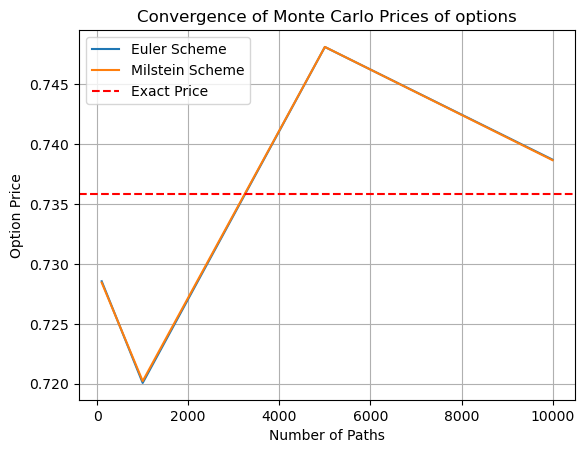

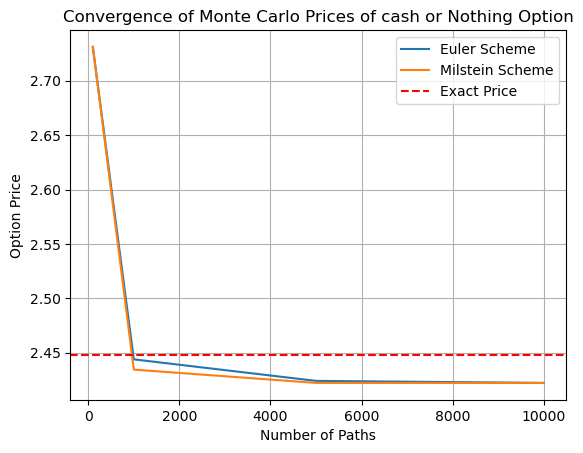

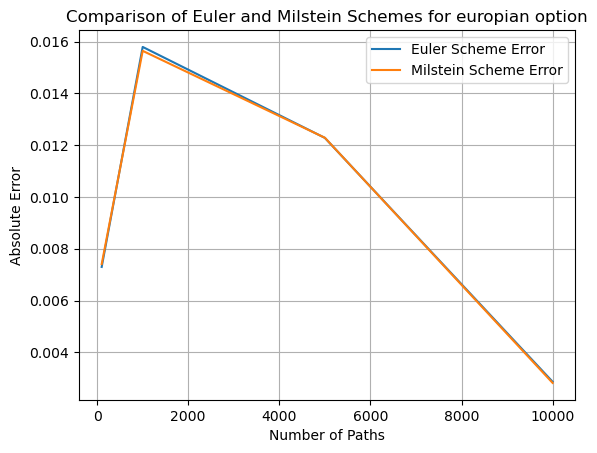

In [10]:
mainCalculation()